---
---

# Zanetti, F., Botter, G., & Camporese, M. (2024)
This is a notebook to reproduce outputs from  [Zanetti, F., Botter, G., & Camporese, M. (2024))](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2023WR035631) 

```{important}
# Cite this work
We believe in a community-driven approach of open-source tools that are
composable and extensible. If you use this notebook cite the work as:
> Zanetti, F., Botter, G., & Camporese, M. (2024). Stream network dynamics of non‐perennial rivers: Insights from integrated surface‐subsurface hydrological modeling of two virtual catchments. Water Resources Research, 60(2), e2023WR035631. https://doi.org/10.1029/2023WR035631
```

:name only: Zanetti
:name: body
:*Nested syntax*: Both name and body may contain **nested syntax**.
:Paragraphs: Since the field marker may be quite long, the second
   and subsequent lines of a paragraph do not have to line up
   with the first line.

The notebooks describes: 
1. **Preprocessing step**:
   - How to build a mesh for the two virtual catchments with different morphology 
   - Exploring atmospheric boundary conditions **Atmbc parameters**

3. **Simulation** (very long, recommended to execute locally): solve the surface-subsurface flow during a year considering different scenarios.

4. **Plot outputs**: analysis of the results
   - Spatial distribution of the **stream network** using a classification threshold analysis based on [Durighetto et al. (2020)](https://doi.org/10.1029/2019WR025563) and [Jaeger et al. (2014)](https://doi.org/10.1007/s00267-005-0311-2). 

```{note} Open-Source

The data set generated and/or analyzed during the current study are available on the online repository, https://researchdata.cab.unipd.it/id/eprint/1092 (Zanetti et al., 2023).
The CATHY model is freely available at [https://bitbucket.org/cathy1_0/cathy/](https://bitbucket.org/cathy1_0/cathy).

```{admonition} What you should already know
In order to complete this tutorial, you should be relatively familiar with using the pyCATHY for:
- Building a mesh from a DEM (See {doc}`../content/SSHydro/index` for more information.)
- Updating soil inputs
- ...
```


```{warning}
Found a bug 🐛/ a typo ? [Email me](mailto:benjamin.mary@ica.csic.es)
```

### Importing the required datasets

Datasets input files are fetched from the https://researchdata.cab.unipd.it/1092/ repository using Pooch.

In [1]:
import zipfile
import pooch
from pathlib import Path

odie = pooch.create(
    path=pooch.os_cache("my-project"),
    base_url="https://researchdata.cab.unipd.it/1092/",
    registry={
        "1/circular_catchment.zip": None,
        "2/elongated_catchment.zip": None,
        #"3/src.zip": None,
    },
)
circular_catchment_data = odie.fetch("1/circular_catchment.zip")
elongated_catchment_data = odie.fetch("2/elongated_catchment.zip")
#src_data = odie.fetch("3/src.zip")
extract_dir = Path('./Zanetti_WRR_2024/')
extract_dir.mkdir(parents=True, exist_ok=True)

In [2]:
# Unzip the file
with zipfile.ZipFile(elongated_catchment_data, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)
# Unzip the file
with zipfile.ZipFile(circular_catchment_data, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)
    

KeyboardInterrupt: 

### Importing the required packages

- `matplotlib` in order to **plot** the data;
- `cathy_tools` is the main object controlling the simulation;
- `pyCATHY.importers` allows you to **read CATHY input/outputs** files;
- `pyCATHY.plotters` is a set of functions in order to plot simulation outputs.

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pyCATHY import cathy_tools
from pyCATHY.importers import cathy_inputs as in_CT
from pyCATHY.importers import cathy_outputs as out_CT
from pyCATHY.plotters import cathy_plots as cplt
from pyCATHY import CATHY

import matplotlib as mpl
# set some default plotting parameters for nicer looking plots
mpl.rcParams.update({"axes.grid":True, "grid.color":"gray", "grid.linestyle":'--','figure.figsize':(10,10)})

### Create a CATHY simulation object

In [4]:
# Initiate a CATHY model
# ------------------------
Z_WRR_2024_scenarioCircular_50mmd = CATHY(dirName='./Zanetti_WRR_2024/circular_catchment/',
                                            prj_name='50mmd'
                                            )

🏁 Initiate CATHY object

```{tip} Multiples scenario

If you want to run multiple scenario and compare them it is recommanded to create a single CATHY object for each of the simulations.
For instance: 

```python
simu_scenario1 = cathy_tools.CATHY(dirName=ThePathToYourProject, prj_name="scenario1")
simu_scenario2 = cathy_tools.CATHY(dirName=ThePathToYourProject, prj_name="scenario2")
```



In [5]:
Z_WRR_2024_scenarioCircular_20mmd = CATHY(dirName='./Zanetti_WRR_2024/circular_catchment/',
                                            prj_name='20mmd'
                                            )

🏁 Initiate CATHY object

We repeat, and create a simulation object for the elongated catchement

In [6]:
Z_WRR_2024_scenarioElongated_50mmd = CATHY(dirName='./Zanetti_WRR_2024/elongated_catchment/',
                                            prj_name='50mmd'
                                            )

🏁 Initiate CATHY object

In [7]:
Z_WRR_2024_scenarioElongated_5mmh = CATHY(dirName='./Zanetti_WRR_2024/elongated_catchment/',
                                            prj_name='5mmh'
                                            )

🏁 Initiate CATHY object

## 1. Preprocessing step

Starting from DEM data (dtm_13.val) and parameters (hap.in) files, the preprocessing produce a complete set of files describing physiographic features of a drainage system. Such files represent the preprocessing input files for CATHY simulation.


### Build the mesh

```{tip}
Outside the region of interest the elevation are set to -9999
```

In [8]:
DEM_circular, header_DEM = Z_WRR_2024_scenarioCircular_50mmd.read_inputs('dem')
DEM_elongated, header_DEM = Z_WRR_2024_scenarioElongated_50mmd.read_inputs('dem')
DEM_circular[DEM_circular==-9999] = np.nan
DEM_elongated[DEM_elongated==-9999] = np.nan

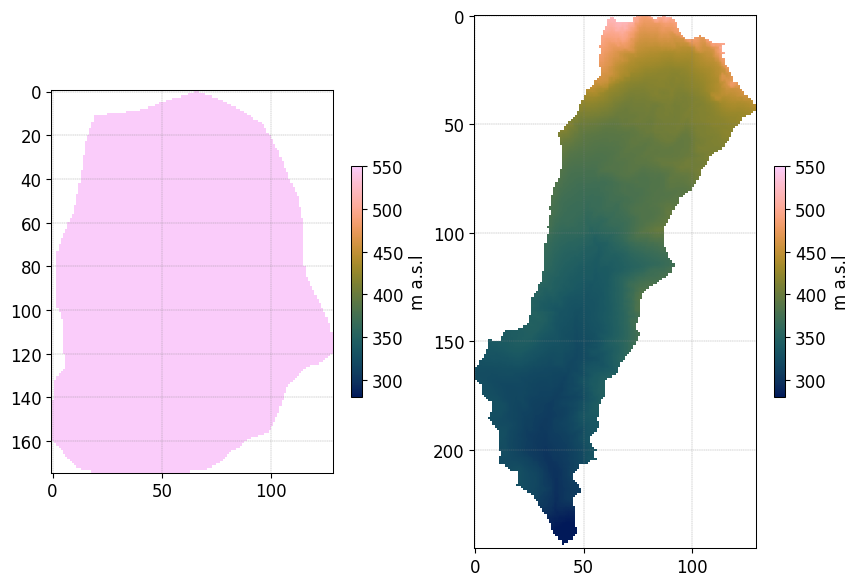

In [9]:
import cmcrameri.cm as cmc

fig, axs = plt.subplots(1,2)
img = axs[0].imshow(DEM_circular,vmin=280,vmax=550,cmap=cmc.batlow)
cbar = plt.colorbar(img,ax=axs[0],shrink=0.3)
cbar.set_label('m a.s.l')

img = axs[1].imshow(DEM_elongated,vmin=280,vmax=550,cmap=cmc.batlow)
cbar = plt.colorbar(img,ax=axs[1],shrink=0.3)
cbar.set_label('m a.s.l')


🔄 Update hap.in file

🔄 update dem_parameters file 

🔄 update dem_parameters file 

(550.0, 800.0)

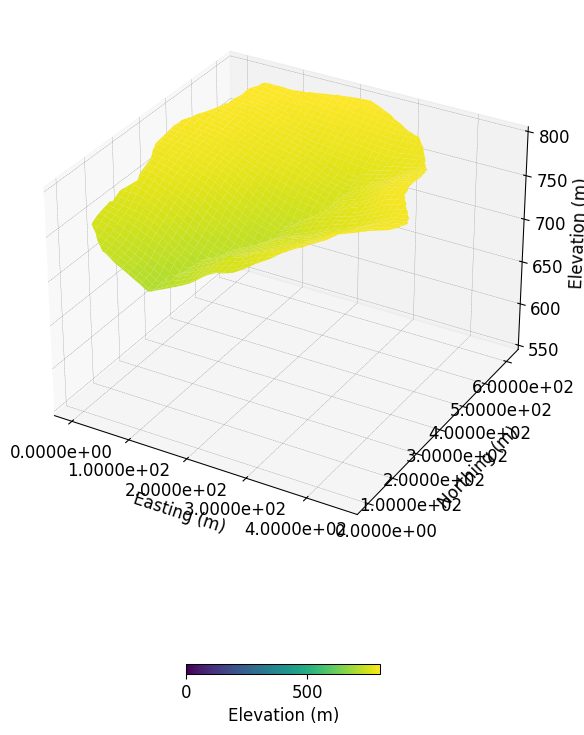

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Z_WRR_2024_scenarioCircular_50mmd.show_input(prop="dem",
                                             ax=ax,
                                              vmin=0
                                            )
ax.set_zlim([550,800])

### Setting the atmospheric boundary conditions

**Scenario 1**, excludes irrigation from the reference simulation. This scenario serves primarily to assess the differences between an agricultural catchment and a natural one.

In order to update the atmospheric boundary conditions we call the following function:
```python
simu.update_atmbc()
```
Remenber that the functions arguments details can be assessed via: 

```python
help(simu.update_atmbc())
```

[5.786e-07, 0.0, 0.0]

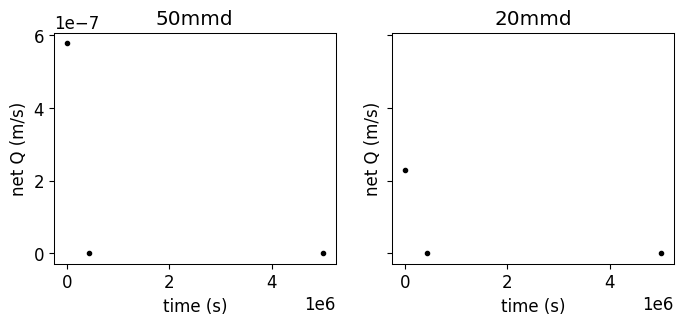

In [11]:
# first we read and plot the current atmbc file 
# --------------------------------
fig, axs = plt.subplots(1,2,sharey=True,figsize=(8,3))
df_atmbc_50mmd = Z_WRR_2024_scenarioCircular_50mmd.read_inputs('atmbc')
df_atmbc_20mmd = Z_WRR_2024_scenarioCircular_20mmd.read_inputs('atmbc')

Z_WRR_2024_scenarioCircular_50mmd.show_input('atmbc',ax=axs[0])
axs[0].set_title('50mmd')
Z_WRR_2024_scenarioCircular_20mmd.show_input('atmbc',ax=axs[1], c='r', marker='v')
axs[1].set_title('20mmd')

df_atmbc_50mmd.value.to_list()

Given the fact that all the values are defined in net Q (m/s), and that all the values are >0, here the scenario exclude the irrigation from the atmospheric boundary conditions.

Let's update the atmbc values without to with irrigation:

In [12]:
# help(Z_WRR_2024_scenarioCircular_50mmd.update_atmbc)

```{tip} I want to change my atmbc input to my simu object

```python
simu.update_atmbc(
                    HSPATM=1,
                    IETO=1,
                    time=[0.0, 432000.0, 5000000.0],
                    netValue=[5.786e-07, 0.0, 0.0],
)
simu.show_input('atmbc')
```

## 2. Run simulation

Once all the inputs files are updated according to the scenario, it is good practice to run first the preprocessor in verbose = True mode to check if the preprocessing step worked. 

Then we can run the processor. As the number of times and points are large in this example it is recommanded to execute it locally.

```python
simu.run_preprocessor(verbose=True)
simu.run_processor(
                   IPRT1=2,
                   )

```{tip} Check before running the simulations
Before running the simulation it is recommanded to check the parm file
```

In [13]:
#simu.read_inputs('parm')
import pandas as pd
parm_file = os.path.join(Z_WRR_2024_scenarioElongated_50mmd.workdir,
                         Z_WRR_2024_scenarioElongated_50mmd.project_name,'input','parm')
parm = in_CT.read_parm(parm_file)
#print(parm)

Among all the parameters (check using parm.keys()) controlling the behavior of the simulation here is a selection of some important ones: 

- `IPRT1` Flag for output of input and coordinate data;
- `TRAFLAG` lag for the choice of the data assimilation scheme;
- `DTMIN` Minimum FLOW3D time step size allowed;
- `NPRT` Number of time values for detailed nodal output and element velocity output;
- `(TIMPRT(I),I=1,NPRT)` Time values for detailed output.

## 3. Plot outputs

### Plot streamflow

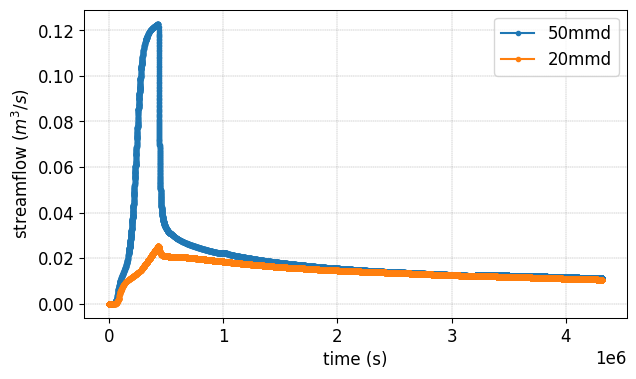

In [14]:
#%% Another interesting graph looking at the **streamflow = f(time)**
fig, ax = plt.subplots(1,figsize=(7,4))
Z_WRR_2024_scenarioCircular_50mmd.show(prop="hgraph",ax=ax)
Z_WRR_2024_scenarioCircular_20mmd.show(prop="hgraph",ax=ax)
ax.legend(['50mmd','20mmd'])


Plot stream network

```{note} Method

"To compute the dynamic active length (L) and to map the stream network spatial distribution, it was necessary to identify a threshold criterion to classify each catchment cell as wet or dry during the post-processing phase." 

**Criteria**:
- a minimum channel water surface width as in [Durighetto et al. (2020)](https://doi.org/10.1029/2019WR025563)
- a minimum discharge as in [Jaeger et al. (2014)](https://doi.org/10.1007/s00267-005-0311-2). 

**Threshold discharge** = 10 ls−1 for both the catchments

In [15]:
threshold = 0.01;        # m3/s = 10 l/s

In [16]:
#%% read netris file
simu2plots = [Z_WRR_2024_scenarioElongated_5mmh,Z_WRR_2024_scenarioElongated_50mmd]
netris = []
for si in simu2plots:
    filename = os.path.join(si.workdir,
                            si.project_name,
                            'output/net.ris')
    netris.append(out_CT.read_netris(filename))

In [17]:
#%% read cq file and apply threshold
Q2plot = []
for i, si in enumerate(simu2plots):
    filename = os.path.join(si.workdir,
                            si.project_name,
                            'output/cq')
    cell_discharge = out_CT.read_cq(filename)
    cell_discharge_thresh = np.zeros(np.shape(cell_discharge)[0])
    for j in range(len(cell_discharge)):
        if cell_discharge[j,-1] <= threshold:
            cell_discharge_thresh[j] = 0
        else:
            cell_discharge_thresh[j] = 1
    QthresholdVAL = np.reshape(cell_discharge_thresh, 
                               (len(netris[i][:,0]), 
                                len(netris[i][0,:])),
                                order='F'
                                )
    QthresholdVAL = np.flipud(QthresholdVAL)
    QthresholdVAL[np.isnan(netris[i])] = np.nan
    QthresholdVAL[QthresholdVAL == 0] = np.nan
    Q2plot.append(QthresholdVAL)
    

In [18]:
# create mask of valid 
idx_Qvalid = []
idy_Qvalid = []
for qi in Q2plot:
    idx_Qvalid.append(np.where(qi==1)[1])
    idy_Qvalid.append(np.where(qi==1)[0])

Plot the result for scenario 5mm/h and 50mmd

Text(0.5, 1.0, '50mm/d')

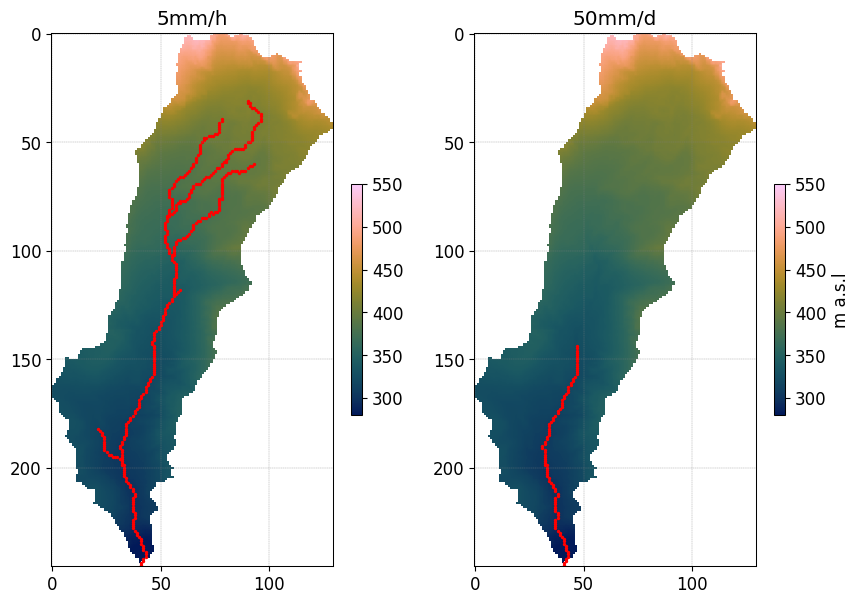

In [19]:
fig, axs = plt.subplots(1,2)

img = axs[0].imshow(DEM_elongated,vmin=280,vmax=550,cmap=cmc.batlow)
img = axs[1].imshow(DEM_elongated,vmin=280,vmax=550,cmap=cmc.batlow)

cbar = plt.colorbar(img,ax=axs[0],shrink=0.3)
cbar = plt.colorbar(img,ax=axs[1],shrink=0.3)
cbar.set_label('m a.s.l')

axs[0].scatter(idx_Qvalid[0], 
           idy_Qvalid[0],
           color='r',
           s=2)
axs[0].set_title('5mm/h')
axs[1].scatter(idx_Qvalid[1], 
           idy_Qvalid[1],
           color='r',
           s=2)
axs[1].set_title('50mm/d')

